# Browse Basin Map Plot



In [1]:
from soda.dataio.conversion.demBuilder import demBuilder
from soda.dataio.conversion.dem import blendDEMs, DEM
from soda.utils.maptools import Contour2Shp, utm2ll
from soda.dataio.suntans.sunpy import Grid, Spatial
from soda.dataio.ugrid.uplot import Plot
from soda.utils.otherplot import axcolorbar

import soda.dataio as io
from soda.utils.maptools import ll2utm, readShpPointLine
from soda.utils.myproj import MyProj

from mpl_toolkits.basemap import Basemap, cm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import matplotlib as mpl
%matplotlib inline
mpl.rcParams['font.size']=14
mpl.rcParams['axes.labelsize']='large'

In [52]:
# Find the station locations

basedir = '/home/suntans/Share/database'
figpath = '../FIGURES/'

dbfile = '%s/UWAOceanDynamics.sqlite'%basedir
tablename = 'observations'

utmzone = 51
isnorth = False

# Variables that we want to show
outvar = ['StationName','X','Y']

# List of variables that we want
condition = 'Variable_Name = "pressure" and \
       StationName LIKE "%%P250%%"'

condition = 'StationName LIKE "%%P250%%"'

query =  io.returnQuery(dbfile, outvar, tablename, condition)

# Find the unique locations only
lon, idx = np.unique(query['X'], return_index=True)

names = np.asarray(query['StationName'])[idx]
lat = np.asarray(query['Y'])[idx]

# Convert to utm
xy = ll2utm( np.column_stack([lon, lat]), utmzone, north=isnorth)

print 'Station Name | Longitude | Latitude'
print ' --- | --- | ---'

staLL=[]
staName=[]
for ii in range(lon.shape[0]):
    ll = names[ii].split('_')
    #station = '%s-%s'%(ll[1],ll[2])
    station = '%s_%s'%(ll[0], ll[1])
    if 'Lander' in station[0:12]:
        staName.append(station[0:12])
    else:
        staName.append(station[0:5])

    staLL.append([lon[ii], lat[ii]])
    #station = names[ii]
    #print '%f | %f | %s'%(xy[ii,0], xy[ii,1], names[ii])
    print '%s | %f | %f '%(staName[ii], lon[ii], lat[ii])

    #print '%s | %f | %f '%(names[ii], lon[ii], lat[ii])

Station Name | Longitude | Latitude
 --- | --- | ---
WP250 | 123.349000 | -13.765900 
NP250 | 123.353500 | -13.762100 
SP250-Lander | 123.353900 | -13.768100 
SP250 | 123.354200 | -13.766900 


Station Name | Longitude | Latitude
 --- | --- | ---
WP250 | 123.349000 | -13.765900 
NP250 | 123.353500 | -13.762100 
SP250-Lander | 123.353900 | -13.768100 
SP250 | 123.354200 | -13.766900 


# Map Plot

In [46]:
P = MyProj(None, utmzone=utmzone, isnorth=isnorth)

In [47]:
basedir = '/home/suntans/Share/ScottReef/DATA/BATHYMETRY'

# These are all of the bathymetry datasets
bathyfiles = [
    '%s/GeoScience_Woodside_Browse_250m_DEM.nc'%basedir,\
    '%s/GA_Browse_SingleBeam_250m_DEM.nc'%basedir,\
    '%s/GA_Browse_MultiBeam_250m_DEM.nc'%basedir,\
    '%s/WEL_Browse_Composite_250m_DEM.nc'%basedir,\
    '%s/Browse_GeoOz_WEL_Blended_250m_DEM.nc'%basedir,\
    '%s/CMAP_250m_DEM.nc'%basedir,\
    '%s/Browse_GeoOzMultibeam_WEL_Blended_250m_DEM.nc'%basedir,\
    '%s/GA_WEL_Multi_Merged_w_GA250_250m_DEM.nc'%basedir,\
    '%s/Browse_Blended_250m_DEM.nc'%basedir,\
   ]
# This is the final dataset
welbathyfile = bathyfiles[7]

# Plot it up
dem = DEM(welbathyfile)

dem.X,dem.Y = P.to_ll(dem.X, dem.Y)


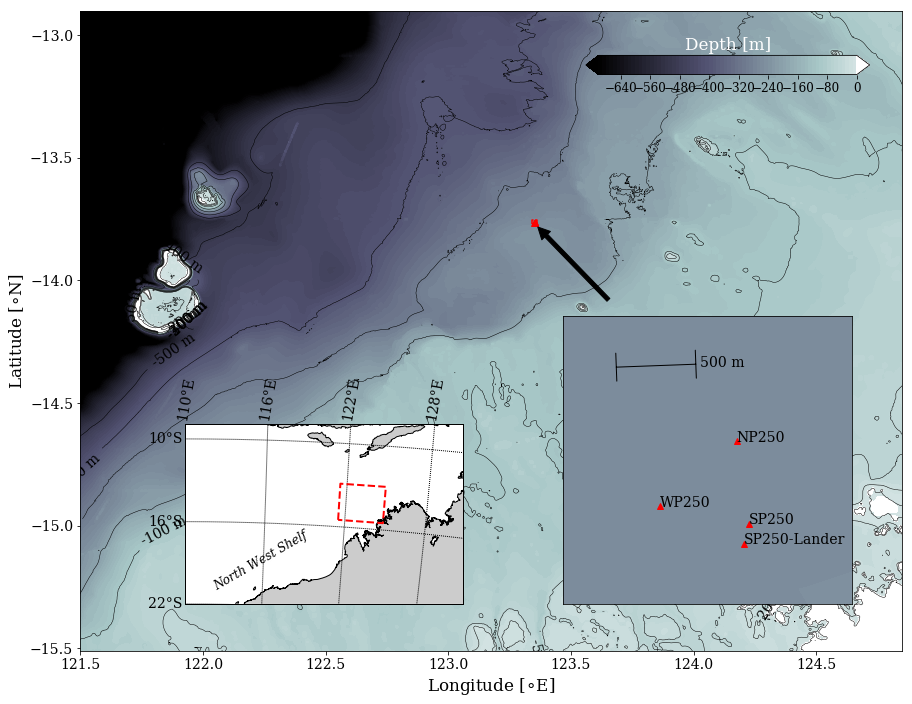

In [56]:
#clevs = np.arange(-2500,10,100.)
clevs = np.arange(-700,10,10.)
majclevs = [-500., -400., -300., -200.,-100.,-50.,-20.,-1.]

def create_box(bbox):
    return np.array([\
                  [bbox[0],bbox[2]],\
                  [bbox[0],bbox[3]],\
                  [bbox[1],bbox[3]],\
                  [bbox[1],bbox[2]],\
                  [bbox[0],bbox[2]],\
                ])

bbox = [121.5, 124.85, -15.51, -12.9]
xybox = create_box(bbox)

bbox2 = [123.34334, 123.36022, -13.77160, -13.75476]
xybox2 = create_box(bbox2)


def plot_map(bbox, text=True):
    ch = plt.contourf(dem.X,dem.Y,dem.Z, clevs,\
                 cmap = 'bone', extend='both', vmax=100, vmin=-700)
    
    for c in ch.collections:
        c.set_edgecolor('face')
        c.set_rasterized(True)
        
    cb = plt.contour(dem.X,dem.Y,dem.Z, majclevs, \
            linestyles='-',colors='k', linewidths=0.5)
    #plt.clabel(cb)
    ax.set_aspect('equal')
    plt.axis(bbox)
    plt.xlabel('Longitude [$\circ$E]')
    plt.ylabel('Latitude [$\circ$N]')


    # Plot the stations
    for ii, name in enumerate(staName):
        #print name,staLL[ii,0],staLL[ii,1]
        plt.plot(staLL[ii][0],staLL[ii][1],'r^')
        if text:
            plt.text(staLL[ii][0],staLL[ii][1], name)
    

    return ch,cb


plt.figure( figsize = (14,10) )

ax = plt.subplot(111)
ch,cb = plot_map(bbox, text=False)
plt.clabel(cb, fmt='%3.0f m', inline_spacing=5,)
plt.plot(xybox2[:,0],xybox2[:,1],'r--')

#plt.plot(xline*1e-3, yline*1e-3, 'm--')


cax= axcolorbar(ch, pos=[0.6, 0.9, 0.3, 0.03])
cax.ax.set_title('Depth [m]', fontdict={'color':'w'})
cax.ax.set_yticklabels(cax.ax.get_yticklabels(), fontcolor='y')

for l in cax.ax.xaxis.get_ticklabels():
    l.set_color('k')
    l.set_fontsize(12)


ax.annotate('', xy=(staLL[0][0], staLL[0][1]), xytext=(staLL[0][0]+0.32, staLL[0][1]-0.33),
    arrowprops=dict(facecolor='black', shrink=0.05),
    )
# Zoom Plot
ax2 = plt.axes([0.53,0.15,0.40,0.40])
plot_map(bbox2)

# Create a scale bar
ax2.annotate('500 m', xy=(bbox2[0]+0.003, bbox2[3]-0.003),\
        xytext=(bbox2[0]+0.008, bbox2[3]-0.003),
    arrowprops=dict(facecolor='black', arrowstyle='|-|'),
    )
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_aspect('equal')

# 
###
# Plot a basemap
###
#xylims = [-98.5, -87.6, 26, 31.1] # North Western Gulf of Mexico
#meridians = np.arange(-98,-87,2.0)
#parallels = np.arange(26,31,2.0)
xylims = [110., 130, -22, -8] # North 
meridians = np.arange(110.,130.,6.0)
parallels = np.arange(-22,-8.,6.0)

#ax=plt.subplot2grid((3,3),(0,2),colspan=1)
ax = plt.axes([0.15,0.15,0.4,0.25])
m = Basemap(projection='stere',llcrnrlat=xylims[2],urcrnrlat=xylims[3],\
            llcrnrlon=xylims[0],urcrnrlon=xylims[1],lat_0=xylims[2],lon_0=xylims[0],\
            resolution='i')
m.drawcoastlines()
m.fillcontinents()
#m.readshapefile(shpfile,'coast')
m.drawparallels(parallels,labels=[1,0,0,0],color='k',fontdict={'color':'k'})
m.drawmeridians(meridians,labels=[0,0,1,0],rotation=80, color='k',fontdict={'color':'k'})
#m.drawparallels(parallels,labels=[1,0,0,0])
#m.drawmeridians(meridians,labels=[0,0,1,0],rotation=80)
m.drawmapboundary(fill_color='w')
#m.drawmapscale(-97.2,30.8,-95.2,29.8,200,barstyle='fancy',fontsize=6)
ax.yaxis.set_label_position("right")

# Label the Gulf
xtxt=122.
ytxt=-14.
xtxt,ytxt=m(xtxt,ytxt)
#plt.text(xtxt,ytxt,'Scott Reef',fontsize=12,fontstyle='italic')

#m.plot(xtxt,ytxt,'o', color='r',linewidth=2)

x,y = m(xybox[:,0],xybox[:,1])
m.plot(x,y,'r--', lw=2)

xtxt,ytxt=m(112., -17.2)
plt.text(xtxt,ytxt,'North West Shelf',fontsize=12,fontstyle='italic', rotation=30.)



# Draw a box around Galveston Bay
#xbox,ybox = m(xbox,ybox)
#m.plot(xbox,ybox,color='r',linewidth=2)

#plt.savefig('%s/ScottReef_Basemap.png'%figpath,dpi=150)
plt.savefig('%s/BrowseBasin_Basemap_150dpi.jpg'%figpath,dpi=150)
#plt.savefig('%s/ScottReef_Basemap_300dpi.jpg'%figpath,dpi=300)


plt.savefig('%s/BrowseBasin_Basemap.pdf'%figpath,dpi=150)

In [8]:
xybox

array([[ 121.5 ,  -15.51],
       [ 121.5 ,  -12.9 ],
       [ 124.85,  -12.9 ],
       [ 124.85,  -15.51],
       [ 121.5 ,  -15.51]])